In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from platform import python_version
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torchvision import datasets, models
import torchvision.transforms as T
import torch.nn.functional as F
import torch.utils.data as data_utils
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
import PIL
from tqdm import tqdm
from torch.utils.data import  DataLoader, Dataset
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import shutil

In [3]:
load_pretrained_models = False

In [4]:
!pip install wget


[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
origin_file_path = "data/origin"
test_folder, train_folder = "data/test_data", "data/train_data"
gan_results_folder, MSNPS_results_folder = "results/gan", "results/MSNPS"
saved_model_folder = "saved_models"
n_epochs = 5
batch_size = 16
# adam:
lr = 0.00008
b1 = 0.5
b2 = 0.999

default_img_size = (128, 128)
default_mask_size = (64, 64)
channels = 3
sample_interval = 500

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if os.path.exists(gan_results_folder):
    shutil.rmtree(gan_results_folder)
if os.path.exists(MSNPS_results_folder):
    shutil.rmtree(MSNPS_results_folder)
os.makedirs(gan_results_folder)
os.makedirs(MSNPS_results_folder)
os.makedirs(saved_model_folder, exist_ok=True)

# Calculate output dims of image discriminator (PatchGAN)
patch_h, patch_w = int(default_mask_size[1] / 2 ** 3), int(default_mask_size[0] / 2 ** 3)
patch = (1, patch_h, patch_w)

## Data Preparation
Downloading the dataset from http://www.cs.ucf.edu/~aroshan/index_files/Dataset_PitOrlManh/zipped%20images/part2.zip, this might take several minutes since the dataset is about 5 GB. Then unzip the file.

In [6]:
import wget
import zipfile

files = ["part1.zip", "part2.zip"]
for down_file in tqdm(files):
    if os.path.exists(down_file):
        continue
    url = f"http://www.cs.ucf.edu/~aroshan/index_files/Dataset_PitOrlManh/zipped images/{down_file}"
    filename = wget.download(url)
    print(filename)

    with zipfile.ZipFile(filename,"r") as zip_ref:
        zip_ref.extractall(origin_file_path)

100%|██████████| 2/2 [00:00<00:00, 666.56it/s]


In [7]:
# import cv2
# masked_file_path = "masked"
# if not os.path.exists(masked_file_path):
#     os.mkdir(masked_file_path)

# for image_file in tqdm(os.listdir(origin_file_path)):
#     input_path = os.path.join(origin_file_path, image_file)
#     if not os.path.isfile(input_path):
#         print(f"{input_path} is not a file, skipping...")
#         continue
#     img = PIL.Image.open(input_path)
#     img_ary = np.array(img, dtype=np.uint8)
#     center = (640, 512)
#     width, height = 400, 300
#     startx, starty = center[0] - width//2, center[1] - height//2
#     img_ary[starty:starty+height, startx:startx+width, :] = 0
#     PIL.Image.fromarray(img_ary).save(os.path.join(masked_file_path, image_file))

We will partition the file into test and train dataset, and then copy them into corresponding test and train folder.

In [8]:
file_list = [x for x in os.listdir(origin_file_path) if os.path.isfile(os.path.join(origin_file_path, x))]
file_list.sort()
file_list = np.array(file_list)
train_length = len(file_list) * 4 // 5
# For reproducible purposes
np.random.seed(0)
train_indices = np.random.choice(len(file_list), train_length, replace = False)
train_mask = np.zeros(file_list.shape, dtype=bool)
train_mask[train_indices] = True

if os.path.exists(test_folder):
    shutil.rmtree(test_folder)
if os.path.exists(train_folder):
    shutil.rmtree(train_folder)

os.mkdir(test_folder)
os.mkdir(train_folder)

for train_file in tqdm(file_list[train_mask]):
    shutil.copyfile(os.path.join(origin_file_path, train_file), os.path.join(train_folder, train_file))
for test_file in tqdm(file_list[~train_mask]):
    shutil.copyfile(os.path.join(origin_file_path, test_file), os.path.join(test_folder, test_file))

100%|██████████| 2639/2639 [00:04<00:00, 531.61it/s]


In [9]:
def apply_mask(img, mask_size, random=True):
    """
    Randomly masks image
    Img: tensor
    maske_size: tuple, (W, H)
    random: boolean, False means center crop
    """
    if not torch.is_tensor(img):
        raise TypeError("Only tensors are allowed")
    channel, y, x = img.size()
    
    y1, x1 = (y - mask_size[1]) // 2, (x - mask_size[0]) // 2
    if random:
        y1, x1 = np.random.randint(0, y - mask_size[1]), np.random.randint(0, x - mask_size[0])
    y2, x2 = y1 + mask_size[1], x1 + mask_size[0]
    masked_part = img[:, y1:y2, x1:x2]
    masked_img = img.clone()
    masked_img[:, y1:y2, x1:x2] = 1

    return masked_img, masked_part, (y1, x1)

As a demonstration, we verify our mask application funciton works:

(1280, 1024)


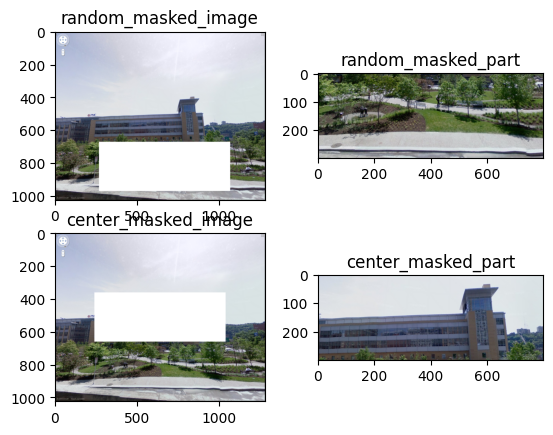

In [10]:
input_path = os.path.join(origin_file_path, "001100_1.jpg")
img = PIL.Image.open(input_path)
print(img.size)
img = T.ToTensor()(img)


test_mask_size = (800, 300)
random_masked_img, random_masked_part, _ = apply_mask(img, test_mask_size, True)

center_masked_img, center_masked_part, _ = apply_mask(img, test_mask_size, False)

fig = plt.figure()
plt.subplot(221)
plt.title("random_masked_image")
plt.imshow(random_masked_img.permute(1, 2, 0))
plt.subplot(222)
plt.title("random_masked_part")
plt.imshow(random_masked_part.permute(1, 2, 0))
plt.subplot(223)
plt.title("center_masked_image")
plt.imshow(center_masked_img.permute(1, 2, 0))
plt.subplot(224)
plt.title("center_masked_part")
plt.imshow(center_masked_part.permute(1, 2, 0))

# PIL.Image.fromarray(img_ary).save(os.path.join(masked_file_path, image_file))

In [11]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mask_size=default_mask_size, train=True):
        self.transform = T.Compose(transforms_)
        self.mask_size = mask_size
        self.train = train
        self.files = sorted([os.path.join(root, x) for x in os.listdir(root) if os.path.isfile(os.path.join(root, x))])


    def __getitem__(self, index):
        img = PIL.Image.open(self.files[index % len(self.files)])
        img = self.transform(img)

        # Use random crop if we are in train mode
        masked_img, masked_part, lefttop_corner = apply_mask(img, self.mask_size, random=self.train)

        return img, masked_img, masked_part, lefttop_corner

    def __len__(self):
        return len(self.files)

In [12]:
transforms_ = [
    T.Resize(default_img_size, PIL.Image.BICUBIC),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
dataloader = DataLoader(
    ImageDataset(train_folder, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)
test_dataloader = DataLoader(
    ImageDataset(test_folder, transforms_=transforms_, train=False),
    batch_size=12,
    shuffle=False,
    num_workers=0,
)

c:\Users\KandaMaya\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [13]:
def save_sample(batches_done, path):
    samples, masked_samples, _, (y1, x1) = next(iter(test_dataloader))
    mask_w, mask_h = test_dataloader.dataset.mask_size
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    y1 = y1[0].item()
    x1 = x1[0].item()
    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples[:, :, y1 : y1 + mask_w, x1 : x1 + mask_h] = gen_mask
    # Save sample
    sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    save_image(sample, os.path.join(path, f"{batches_done}.png") , nrow=6, normalize=True)

In [14]:
class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2),
        )

        self.connection = nn.Conv2d(512, 4000, 1)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4000, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.ELU(),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.ELU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ELU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ELU(),
        )

        self.upsampler = nn.Sequential(
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.encoder(x)
        output = self.connection(output)
        output = self.decoder(output)
        output = self.upsampler(output)

        return output


class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 3, stride=1, padding=1),
        )

    def forward(self, img):
        return self.model(img)

In [15]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [16]:
# Loss function
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()

# Initialize generator and discriminator
generator = Generator(channels=channels)
discriminator = Discriminator(channels=channels)

generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)
pixelwise_loss.to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [17]:
if load_pretrained_models:
    generator.load_state_dict(torch.load(os.path.join(saved_model_folder,"generator.pth")))
    discriminator.load_state_dict(torch.load(os.path.join(saved_model_folder, "discriminator.pth")))
    print("Using pre-trained Context-Encoder GAN model!")

In [18]:
gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []

for epoch in range(n_epochs):
    
    ### Training ###
    gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0
    tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
    for i, data in enumerate(tqdm_bar):
        imgs, masked_imgs, masked_parts, _ = data
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)
        # Configure input
        imgs = Variable(imgs.type(Tensor))
        masked_imgs = Variable(masked_imgs.type(Tensor))
        masked_parts = Variable(masked_parts.type(Tensor))

        ## Train Generator ##
        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_parts = generator(masked_imgs)
        # Adversarial and pixelwise loss
        g_adv = adversarial_loss(discriminator(gen_parts), valid)
        g_pixel = pixelwise_loss(gen_parts, masked_parts)
        # Total loss
        g_loss = 0.001 * g_adv + 0.999 * g_pixel

        g_loss.backward()
        optimizer_G.step()

        ## Train Discriminator ##
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(masked_parts), valid)
        fake_loss = adversarial_loss(discriminator(gen_parts.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
        
        gen_adv_loss, gen_pixel_loss, disc_loss
        gen_adv_losses, gen_pixel_losses, disc_losses, counter
        
        gen_adv_loss += g_adv.item()
        gen_pixel_loss += g_pixel.item()
        gen_adv_losses.append(g_adv.item())
        gen_pixel_losses.append(g_pixel.item())
        disc_loss += d_loss.item()
        disc_losses.append(d_loss.item())
        counter.append(i*batch_size + imgs.size(0) + epoch*len(dataloader.dataset))
        tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1))
        
        # Generate sample at sample interval
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_sample(batches_done, gan_results_folder)
            

Training Epoch 4 : 100%|██████████| 660/660 [03:26<00:00,  3.20it/s, disc_loss=0.0122, gen_adv_loss=0.973, gen_pixel_loss=0.266]


In [19]:
torch.save(generator.state_dict(), os.path.join(saved_model_folder,"generator.pth"))
torch.save(discriminator.state_dict(), os.path.join(saved_model_folder, "discriminator.pth"))

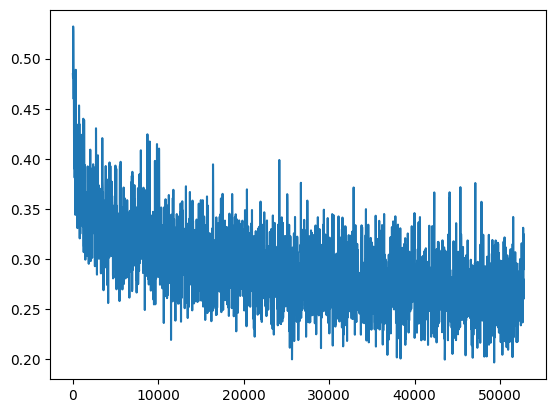

In [20]:
# import plotly
# import plotly.express as px
# import plotly.graph_objects as go
import matplotlib.pyplot as plt

# fig = go.Figure()
plt.plot(counter, gen_pixel_losses)

plt.show()

Using next(iter(_)) we obtain a tensor with dimension (batch_size, num_channels, size, size)

# MSNPS!

In [21]:
# from places2_train import Places2Data, MEAN, STDDEV
LAMBDAS = {"hole": 6.0, "tv": 2.0, "perceptual": 0.05, "style": 240.0}

def gram_matrix(feature_matrix):
	(batch, channel, h, w) = feature_matrix.size()
	feature_matrix = feature_matrix.view(batch, channel, h * w)
	feature_matrix_t = feature_matrix.transpose(1, 2)

	# batch matrix multiplication * normalization factor K_n
	# (batch, channel, h * w) x (batch, h * w, channel) ==> (batch, channel, channel)
	gram = torch.bmm(feature_matrix, feature_matrix_t) / (channel * h * w)

	# size = (batch, channel, channel)
	return gram


def perceptual_loss(h_out, h_gt, l1):
	loss = 0.0
	for i in range(len(h_out)):
		loss += l1(h_out[i], h_gt[i])
	return loss


def style_loss(h_out, h_gt, l1):
	loss = 0.0

	for i in range(len(h_out)):
		loss += l1(gram_matrix(h_out[i]), gram_matrix(h_gt[i]))

	return loss


# computes TV loss over entire composed image since gradient will not be passed backward to input
def total_variation_loss(image, l1):
    # shift one pixel and get loss1 difference (for both x and y direction)
    loss = l1(image[:, :, :, :-1], image[:, :, :, 1:]) + l1(image[:, :, :-1, :], image[:, :, 1:, :])
    return loss

class CalculateLoss(nn.Module):
	def __init__(self):
		super().__init__()
		# Use VGG16 for better texture
		vgg16 = models.vgg16(pretrained=True)
		self.vgg_layers = [vgg16.features[:5], vgg16.features[5:10], vgg16.features[10:17]]
		for layer in self.vgg_layers:
			layer.to(device)
			for param in layer.parameters():
				param.requires_grad = False

		self.l1 = nn.L1Loss()
	
	def apply_vgg(self, input):
		results = [input]
		for layer in self.vgg_layers:
			results.append(layer(results[-1]))
		return results[1:]

	def forward(self, input_x, output, ground_truth, coords, mask_size):
		composed_output = input_x.clone().to(device)
		for i in range(len(input_x)):
			y1 = coords[0][i].item()
			x1 = coords[1][i].item()
			composed_output[i, :, y1:y1+mask_size[0], x1:x1+mask_size[1]] = output[i]

		fs_output = self.apply_vgg(output)
		fs_ground_truth = self.apply_vgg(ground_truth)

		loss_dict = dict()

		loss_dict["hole"] = self.l1(output, ground_truth) * LAMBDAS["hole"]
		loss_dict["perceptual"] = perceptual_loss(fs_output, fs_ground_truth, self.l1) * LAMBDAS["perceptual"]
		loss_dict["style"] = style_loss(fs_output, fs_ground_truth, self.l1) * LAMBDAS["style"]
		loss_dict["tv"] = total_variation_loss(composed_output, self.l1) * LAMBDAS["tv"]

		return loss_dict

def requires_grad(param):
	return param.requires_grad

model = Generator(channels=channels).to(device)
optimizer = torch.optim.Adam(filter(requires_grad, model.parameters()), lr=lr)
loss_func = CalculateLoss().to(device)

c:\Users\KandaMaya\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\KandaMaya\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
if load_pretrained_models:
    model.load_state_dict(torch.load(os.path.join(saved_model_folder,"MSNPS_model.pth")))

In [23]:
texture_losses = []
for epoch in range(n_epochs):
    tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
    for i, data in enumerate(tqdm_bar):
        imgs, masked_imgs, masked_parts, coords = data

        # Sets model to train mode
        model.train()
        masked_imgs = Variable(masked_imgs.type(Tensor))
        masked_parts = Variable(masked_parts.type(Tensor))
        # Forward-propagates images through net
        # Mask is also propagated, though it is usually gone by the decoding stage
        gen_parts = model(masked_imgs)

        loss_dict = loss_func(imgs, gen_parts, masked_parts, coords, dataloader.dataset.mask_size)
        loss = 0.0

        # sums up each loss value
        for key, value in loss_dict.items():
            loss += value

        # Resets gradient accumulator in optimizer
        optimizer.zero_grad()
        # back-propogates gradients through model weights
        loss.backward()
        # updates the weights
        optimizer.step()
        texture_losses.append(loss.item())
        # Save model
        batches_done = epoch * len(dataloader) + i
        tqdm_bar.set_postfix(loss=loss)
        if batches_done % sample_interval == 0:
            save_sample(batches_done, MSNPS_results_folder)


Training Epoch 4 : 100%|██████████| 660/660 [03:29<00:00,  3.15it/s, loss=tensor(6.1767, device='cuda:0', grad_fn=<AddBackward0>)]


In [24]:
torch.save(model.state_dict(), os.path.join(saved_model_folder, "MSNPS_model.pth"))

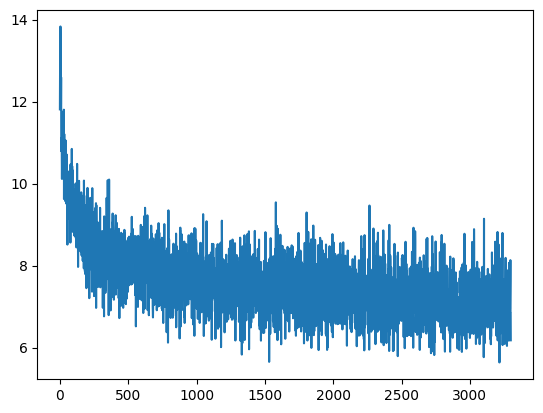

In [26]:
# import plotly
# import plotly.express as px
# import plotly.graph_objects as go
import matplotlib.pyplot as plt

# fig = go.Figure()
plt.plot(texture_losses)

plt.show()